# Table Segmentation Training

This notebook shows how to train a table segmentation model on the **SegmentedTables** dataset. You can download the model weights at https://github.com/paperswithcode/axcell/releases/download/v1.0/models.tar.xz.

In [2]:
from axcell.helpers.datasets import read_tables_annotations
from pathlib import Path
import pandas as pd

# V1_URL = 'https://github.com/paperswithcode/axcell/releases/download/v1.0/'
# SEGMENTED_TABLES_URL = V1_URL + 'segmented-tables.json.xz'

# segmented_tables_annotations = read_tables_annotations(SEGMENTED_TABLES_URL)
proj_path = Path('/data/yuzelou/axcell')
data_path = proj_path.parents[0] / 'data'

In [3]:
from axcell.data.paper_collection import PaperCollection

# SEGMENTED_TABLES_PAPERS = Path('/mnt/efs/pwc/data/arxiv/sources/segmented-tables/papers')
# pc = PaperCollection.from_files(SEGMENTED_TABLES_PAPERS, annotations=segmented_tables_annotations.to_dict(orient='record'))


pc = PaperCollection.from_pickle(data_path / 'mypapers_annotated.pkl')

We convert papers and annotations into a dataframe with features: for each cell we get its content, row and column contexts, styles, references, etc. Additionally we query the elasticsearch instance with cell's content as query to search in a given paper for text fragments with this content. (Run `docker-compose up -d` from the `axcell` repository to start an elasticsearch instance.) We first ensure that all papers from `pc` are stored in the instance:

In [4]:
from axcell.data.structure import CellEvidenceExtractor

cell_evidences = CellEvidenceExtractor() # sets up elasticsearch connection on creation
for paper in pc:
    paper.text.save()

In [6]:
from joblib import delayed, Parallel
                
def process_single(index):
    cell_evidences = CellEvidenceExtractor()
    paper = pc[index]
    leaderboards = [table for table in paper.tables if 'leaderboard' in table.gold_tags.split(',')]
    evidences = cell_evidences(paper, leaderboards, paper_limit=30, corpus_limit=0)
    evidences['fold'] = paper.gold_tags
    evidences.header.fillna('', inplace=True)
    return evidences

In [7]:
%%time

evidences = Parallel(backend='multiprocessing', n_jobs=-1)(delayed(process_single)(index) for index in range(len(pc)))

CPU times: user 1.26 s, sys: 837 ms, total: 2.1 s
Wall time: 34.5 s


In [9]:
evidences = pd.concat(evidences)
evidences.to_pickle(data_path /'cell_evidences.pkl')

In [3]:
evidences = pd.read_pickle(data_path /'cell_evidences.pkl')

In [4]:
import pandas as pd
import re
from collections import OrderedDict
from fastai.text import *
from axcell.models.structure.structure_predictor import TableStructurePredictor


# make sure the training dataframe is batch_size aligned
def align_df(df, batch_size):
    aligned_len = ( len(df) // batch_size ) * batch_size
    return df.iloc[:aligned_len]


def dataframes_to_databunch(base_path, train_df, valid_df, test_df, batch_size, processor):
    columns = ["label", "text", "cell_reference", "cell_styles", "cell_layout", "cell_content", "row_context", "col_context"]
    text_cols=["cell_styles", "cell_layout", "text", "cell_content", "row_context", "col_context", "cell_reference"]
    train_df, valid_df, test_df = train_df[columns], valid_df[columns], test_df[columns]
    
    label_cols = ["label"]
    train_tl = TextList.from_df(train_df, base_path, cols=text_cols, processor=processor)
    valid_tl = TextList.from_df(valid_df, base_path, cols=text_cols, processor=processor)
    test_tl  = TextList.from_df(test_df,  base_path, cols=text_cols, processor=processor)
    

    src = ItemLists(base_path, train_tl, valid_tl)\
        .label_from_df(cols=label_cols)
    src.add_test(test_tl)
    
    data_clas = src.databunch(bs=batch_size)
    return data_clas

def get_databunch(experiment, df, processor):
    is_test = df.fold == experiment.test_split
    is_valid = df.fold == experiment.valid_split
    test_df_all = df[is_test].copy()
    valid_df_all = df[is_valid].copy()
    train_df_all = df[(~is_test) & (~is_valid)].copy()
    train_df_all, valid_df_all, test_df_all = experiment.transform_df(train_df_all, valid_df_all, test_df_all)

    train_df, train_df_num = TableStructurePredictor.keep_alphacells(train_df_all)
    valid_df, valid_df_num = TableStructurePredictor.keep_alphacells(valid_df_all)
    test_df, test_df_num = TableStructurePredictor.keep_alphacells(test_df_all)
    train_df = align_df(train_df, experiment.BS)

    data_clas = dataframes_to_databunch(BASE_DIR, train_df, valid_df, test_df, experiment.BS, processor)
    return train_df, valid_df, test_df, data_clas

In [6]:
from axcell.models.structure.experiment import experiments_grid
from axcell.models.structure.ulmfit_experiment import ULMFiTExperiment


EXPERIMENTS_DIR = './experiments/segmentation'
BASE_DIR = Path('./models')

processor = processor = SPProcessor(
    sp_model=BASE_DIR / 'tmp' / 'spm.model',
    sp_vocab=BASE_DIR / 'tmp' / 'spm.vocab',
    mark_fields=True
)


experiment = ULMFiTExperiment(remove_num=False, drop_duplicates=False,
    this_paper=True, merge_fragments=True, merge_type='concat',
    evidence_source='text_highlited', split_btags=True, fixed_tokenizer=True,
    fixed_this_paper=True, mask=True, evidence_limit=None, context_tokens=None,
    lowercase=True, drop_mult=0.15, fp16=True, train_on_easy=False,
    dataset="segmented-tables",
    test_split='speech_rec',
    valid_split='img_class',
    pretrained_lm='lm'
)

In [7]:
train_df, valid_df, test_df, data_clas = get_databunch(experiment, evidences, processor)
model = experiment.get_trained_model(data_clas)
# experiment.evaluate(model, train_df, valid_df, test_df)

Setting clas seed to 42


epoch,train_loss,valid_loss,accuracy,time
0,0.544938,0.923116,0.680765,00:52


epoch,train_loss,valid_loss,accuracy,time
0,0.363302,0.735967,0.756294,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.234859,0.628784,0.801611,01:59
1,0.177626,0.663931,0.808661,01:59
2,0.148152,0.700336,0.820745,01:59
3,0.087183,0.754452,0.815710,01:59
4,0.051878,1.069942,0.794562,01:59
5,0.033946,0.806247,0.833837,01:59
6,0.020649,0.831158,0.821752,01:59
7,0.015466,0.954704,0.813696,01:59


In [ ]:
from fastai.text import *
from fastai.text.learner import _model_meta

cfg = _model_meta[AWD_LSTM]['config_clas'].copy()
cfg['n_layers'] = 3

clas = text_classifier_learner(data_clas, AWD_LSTM, config=cfg, drop_mult=0.15, metrics=None)
clas.load(proj_path / 'notebooks' / 'training' / 'experiments' / 'segmentation' / f'{valid_split}_{test_split}')

In [9]:
experiment._model.save(proj_path / 'notebooks' / 'training' / 'experiments' / 'segmentation' / f"{experiment.valid_split}_{experiment.test_split}" )

## Evaluate a model

In [20]:
class Labels(Enum):
    OTHER=0
    DATASET=1
    PAPER_MODEL=2
    COMPETING_MODEL=3
    METRIC=4
    EMPTY=5

label_map = {
    "dataset": Labels.DATASET.value,
    "dataset-sub": Labels.DATASET.value,
    "model-paper": Labels.PAPER_MODEL.value,
    "model-best": Labels.PAPER_MODEL.value,
    "model-ensemble": Labels.PAPER_MODEL.value,
    "model-competing": Labels.COMPETING_MODEL.value,
    "dataset-metric": Labels.METRIC.value
}

label_map_reverse = {
    0: "other",
    1: "dataset",
    2: "model",
    3: "model",
    4: "metric"
}

def process_probs(probs, df):
    preds = np.argmax(probs, axis=1)
    df['pred'] = preds
    df['pred_class'] = df['pred'].apply(lambda x: label_map_reverse[x])
    df['label_class'] = df['label'].apply(lambda x: label_map_reverse[x])
    df['is_correct'] = df['pred_class'] == df['label_class']
    return df

def compute_f1(df):
    return df['is_correct'].sum() / len(df['is_correct'])


In [22]:
test_probs = model.get_preds(ds_type=DatasetType.Test, ordered=True)[0].cpu().numpy()
valid_probs = model.get_preds(ds_type=DatasetType.Valid, ordered=True)[0].cpu().numpy()

valid_df = process_probs(valid_probs, valid_df)
test_df = process_probs(test_probs, test_df)

In [23]:
print(f"valid micro f1: {compute_f1(valid_df)}")
print(f"test micro f1: {compute_f1(test_df)}")

0.8469284994964753

In [41]:
test_df[test_df['ext_id'] == "1904.03288v1/table_05.csv/0/3"]

,ext_id,cell_content,cell_type,row_context,col_context,cell_reference,cell_layout,cell_styles,text,label,pred,is_correct,pred_class,label_class
2326,1904.03288v1/table_05.csv/0/3,dev-clean,dataset-sub,Model border E2E border LM border dev-clean bo...,dev-clean border 3.02 border 2.56 border - bor...,False,border-tt align-center,True,re-scale gradients glt before calculating the ...,1,0,False,other,dataset


In [40]:
test_df[['ext_id', 'cell_content', 'label_class', 'pred_class', 'is_correct']].to_csv(proj_path / 'notebooks' / 'training' / 'experiments' / 'segmentation' / f'{valid_split}_{test_split}_testRst.csv', index=False)

train dataset
 * accuracy: 0.997
 * μ-precision: 0.996
 * μ-recall: 1.000
valid dataset
 * accuracy: 0.830
 * μ-precision: 0.858
 * μ-recall: 0.914
test dataset
 * accuracy: 0.670
 * μ-precision: 0.616
 * μ-recall: 0.972


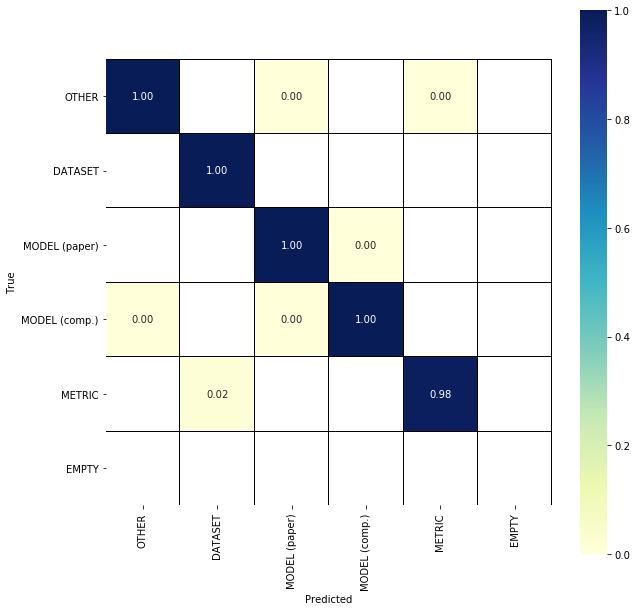

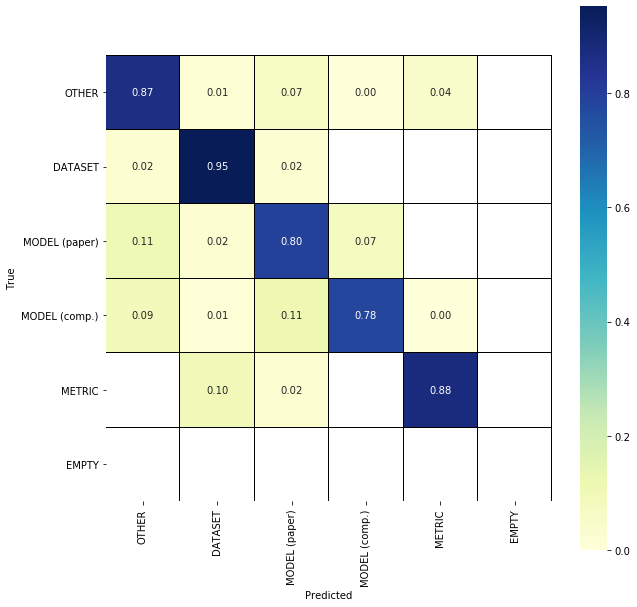

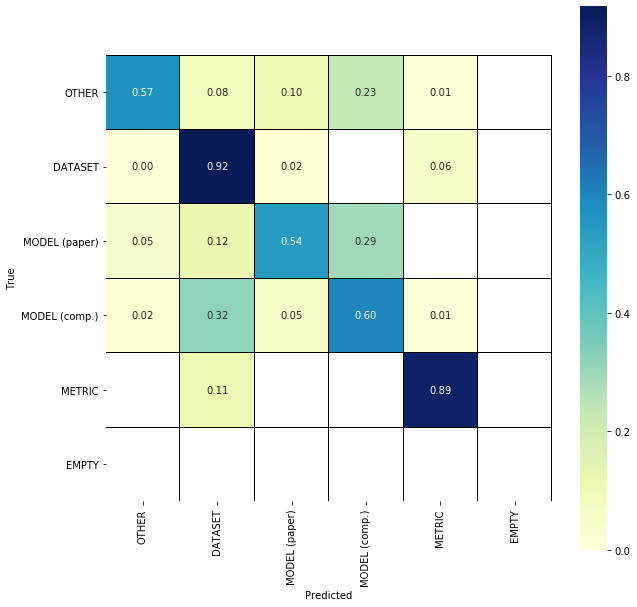

In [14]:
experiment.show_results(full_cm=False)